In [24]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

# Dataset

In [25]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [26]:
def get_data(batch_size):

    datasets = {
        'train' : XORDataset(200),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [27]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.layers = nn.Sequential(
            self.linear, 
            self.Sigmoid, 
            self.linear2
        )
        # custom weight initialization
        nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
        for layer in nnLinearLayers:
            nn.init.normal_(layer.weight)

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [55]:
class learner():

    def __init__(self, model, lr, opt_name, loss_fn=nn.MSELoss()):
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(self.model.parameters(), lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

## get_model and select optimizer

In [29]:
def get_model(lr):
    model = XORnet()

    # optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    return model, optimizer

In [30]:
loss_fn = nn.MSELoss() 

In [31]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. \nWe average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of\nepochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest\nnumber of epochs of the two networks that reached 100% training accuracy in 10 runs.'

# class statsLogger

In [46]:
class statsLogger():
    def __init__(self):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):
        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        minibatch_accuracy = minibatch_num_corrects.item()/pred.shape[0]
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        self.accuracies.append(100 * self.epoch_correct_samples / self.epoch_total_samples)
        
    

In [47]:
def fit(model, optimizer, loaders, epochs):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for xb, yb in loaders['train']:

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }


In [63]:
def plotTraining(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('loss')

    plt.legend()
    plt.show()

# TRAINING !!! 

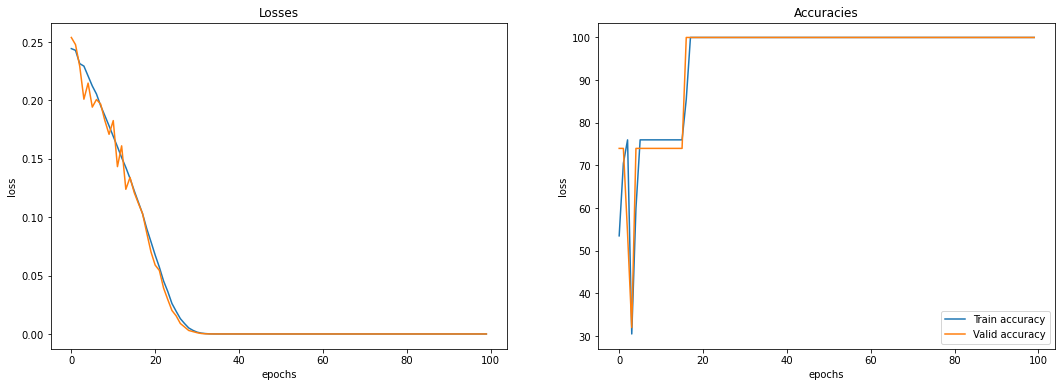

In [64]:
lr = 0.03
bs = 40
datasets, loaders = get_data(bs)
Xorln = learner(XORnet(), lr, 'adam')
model, opt, loss_fn = Xorln.get_model()

epochs=100
loggers = fit(model, opt, loaders, epochs)
plotTraining(loggers, Xorln)

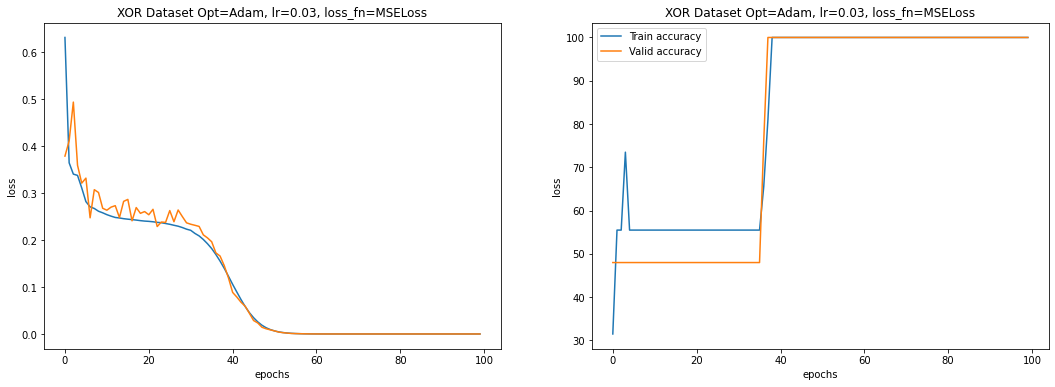

In [62]:
plotTraining(loggers, Xorln)